 # Pre-processing

In [1]:
#TODO - Apply image segmentation before classification, 
#https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import pandas as pd
import os
import random
import glob
import itertools
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Input, Dense, Dropout, Flatten, BatchNormalization, AveragePooling2D
from keras.layers import GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import RMSprop, Adam
from keras import backend as K
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, auc, roc_curve
import tensorflow as tf
%matplotlib inline

TRAIN_DIR = 'data/train'
TEST_DIR = 'data/test'
NO_PNEUMONIA = 0
PNEUMONIA = 1
IMG_DIMEN = 224
BATCH_SIZE = 32
RGB_CHANNELS = 3

/Users/kkoehncke/anaconda/envs/standard_3_6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/kkoehncke/anaconda/envs/standard_3_6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#Code excerpt from Keras Website; allows for reproducibility
os.environ['PYTHONHASHSEED'] = '0'

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.

np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

random.seed(12345)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of
# non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(1234)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [3]:
#Let's examine how many images comprise our training set
#We use the following convention
#
#0 = No Pneumonia
#1 = Pneumonia

def read_images(directory):
    X = []
    y = []
    normal_imgs = glob.glob(directory + '/NORMAL/*.jpeg')
    infected_imgs = glob.glob(directory + '/PNEUMONIA/*.jpeg')
    for img in normal_imgs:
        read_img = load_img(img, target_size=(IMG_DIMEN, IMG_DIMEN, RGB_CHANNELS))
        X.append(img_to_array(read_img))
        y.append(NO_PNEUMONIA)
    for img in infected_imgs:
        read_img = load_img(img, target_size=(IMG_DIMEN, IMG_DIMEN, RGB_CHANNELS))
        X.append(img_to_array(read_img))
        y.append(PNEUMONIA)
    #Don't forget to normalize our images
    return np.asarray(X, dtype=np.float32)/255, to_categorical(np.asarray(y, dtype=np.float32), num_classes=2)

In [4]:
#We note that the given validation set consisted of 16 images, so we opted to merge the
#validation set into the training set and create a validation set at the time of training
X_train, y_train = read_images(TRAIN_DIR)
X_test, y_test = read_images(TEST_DIR)

In [5]:
#Let's see a few images of our classes 
infected_imgs  =  os.listdir(TRAIN_DIR + "/PNEUMONIA")
non_infected_imgs = os.listdir(TRAIN_DIR + "/NORMAL")

#Function that will randomly choose n images and display
def show_imgs(n):
    _, ax = plt.subplots(n,2, figsize=(10,30))
    for row_n in range(n):
        i = random.randrange(0, len(X_train[0]))
        img_p = load_img(TRAIN_DIR + "/PNEUMONIA/" + infected_imgs[i], target_size=(IMG_DIMEN, IMG_DIMEN))
        img_n = load_img(TRAIN_DIR+"/NORMAL/"+ non_infected_imgs[i], target_size=(IMG_DIMEN, IMG_DIMEN))
        ax[row_n, 0].imshow(img_p)
        ax[row_n, 0].set_xlabel('Class: Pneumonia')
        ax[row_n, 1].imshow(img_n)
        ax[row_n, 1].set_xlabel('Class: No Pneumonia')

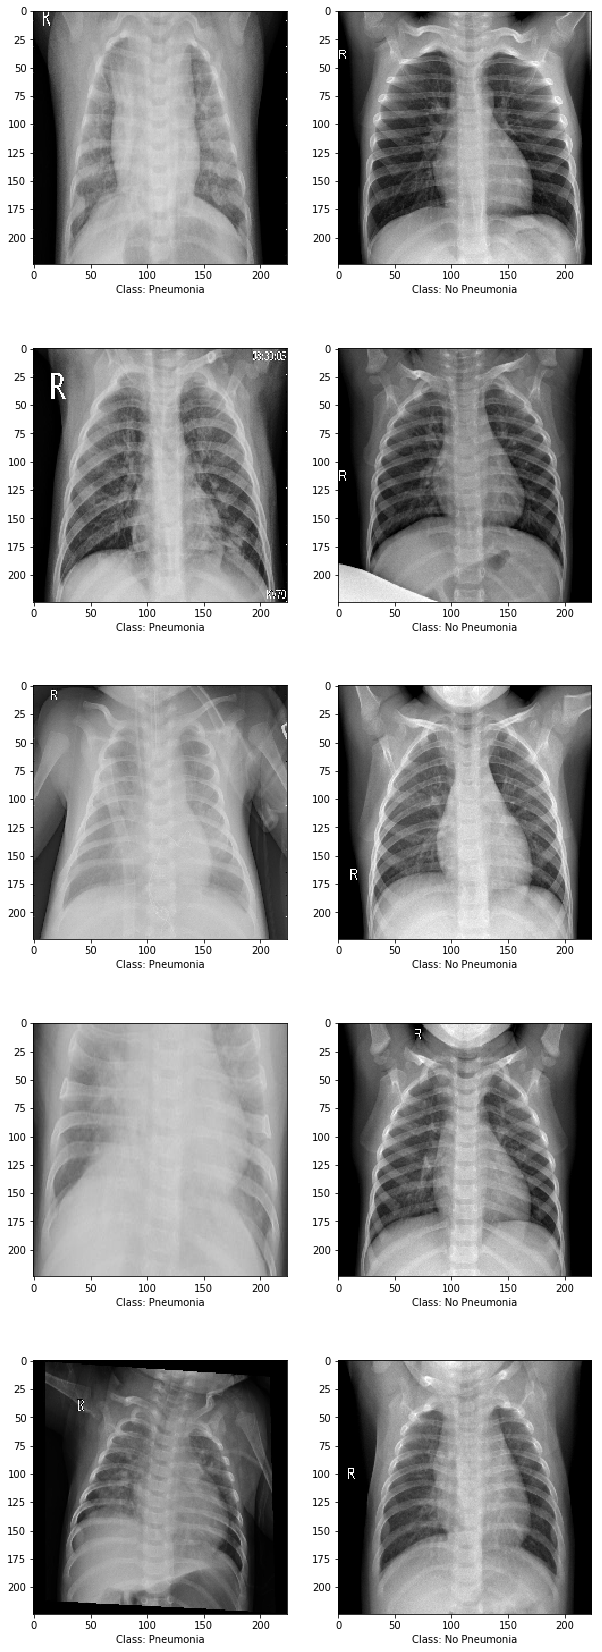

In [6]:
show_imgs(5)

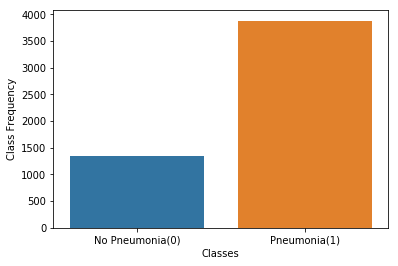

In [7]:
#Let's examine the distribution of our binary classes for our training set
count_classes = np.sum(y_train, axis = 0)
sns.barplot(x = ['No Pneumonia(0)', 'Pneumonia(1)'], y = count_classes)
plt.ylabel('Class Frequency')
plt.xlabel('Classes')
plt.show()

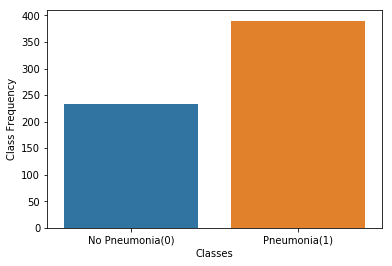

In [8]:
#Let's examine the distribution of our binary classes for our testing set
count_classes = np.sum(y_test, axis = 0)
sns.barplot(x = ['No Pneumonia(0)', 'Pneumonia(1)'], y = count_classes)
plt.ylabel('Class Frequency')
plt.xlabel('Classes')
plt.show()

# Model 

In [9]:
#Calculate class weights so we can account for the imbalance in classes
from sklearn.utils import class_weight
y_ints = [y.argmax() for y in y_train]
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_ints)
feed_class_weights = {0: class_weights[0],
                      1: class_weights[1]}

In [10]:
#Define our image augmentator with following properties:
# Gray Scale
# Horizontal Flips
# Random Brightness
# Highlight edges
from imgaug import augmenters as iaa
seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Grayscale(1.0), 
    iaa.EdgeDetect(0.5),
    iaa.Multiply((1.2, 1.5))
])

In [11]:
def generator(features, labels):
    # Create empty arrays to contain batch of features and labels#
    batch_features = np.zeros((BATCH_SIZE, IMG_DIMEN, IMG_DIMEN, RGB_CHANNELS))
    #Note we use a shape of (BATCH_SIZE, 2) as we one-hot encoded our target class
    #and we have two classes in this given problem
    batch_labels = np.zeros((BATCH_SIZE, 2))
    while True:
        for i in range(BATCH_SIZE):
             # choose random index in features
             index = np.random.choice(len(features),1)
             batch_features[i] = seq.augment_images(features[index])
             batch_labels[i] = labels[index]
        yield batch_features, batch_labels

In [12]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
#lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=1)
es = EarlyStopping(patience=3)
chkpt = ModelCheckpoint(filepath='best_model_todate', save_best_only=True, save_weights_only=True)

In [13]:
#Define our InceptionV3 Model & apply transfer learning
base_model = InceptionV3(input_shape=(IMG_DIMEN, IMG_DIMEN, RGB_CHANNELS), weights='imagenet', 
                         include_top=False)
#Build our FC layers
#TODO - Tune layer # and activation fnct
x = base_model.output
x = BatchNormalization(scale=False)(x)
x = Dropout(0.6, name='Dropout_1')(x)
x = GlobalAveragePooling2D(name='pool_output')(x)
#x = Flatten(name='flatten')(x)
# x = Dense(1024, activation='relu', name='FC_1024')(x)
#x = Dense(64, activation='relu', name='FC_256')(x)
x = Dropout(0.4, name='Dropout_2')(x)
#x = BatchNormalization()(x)
predictions = Dense(2, activation='sigmoid', name='FC_output')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [22]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 111, 111, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 111, 111, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [15]:
#We want to train the third Inception block on our medical images
#to try and capture some of the distinct features
# for layer in model.layers[:249]:
#     layer.trainable = False
# for layer in model.layers[249:]:
#     layer.trainable = True
for layer in base_model.layers:
    layer.trainable = False
model.compile(optimizer = Adam(lr=0.0001, decay=1e-5), loss='categorical_crossentropy', 
              metrics=['accuracy'])
#model.summary()

In [16]:
epochs = 20
history = model.fit_generator(generator(X_train, y_train), 
                    validation_data = (X_test, y_test),
                    shuffle = True, epochs = epochs, steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
                    class_weight = feed_class_weights, callbacks=[es, chkpt])

Epoch 1/20
163/163 [==============================] - 1760s 11s/step - loss: 0.6294 - acc: 0.6242 - val_loss: 1.1077 - val_acc: 0.4087
Epoch 2/20
163/163 [==============================] - 1696s 10s/step - loss: 0.5042 - acc: 0.7611 - val_loss: 1.0210 - val_acc: 0.4215
Epoch 3/20
163/163 [==============================] - 1667s 10s/step - loss: 0.4239 - acc: 0.8127 - val_loss: 0.8804 - val_acc: 0.4776
Epoch 4/20
163/163 [==============================] - 1756s 11s/step - loss: 0.3750 - acc: 0.8411 - val_loss: 0.7417 - val_acc: 0.5385
Epoch 5/20
163/163 [==============================] - 1754s 11s/step - loss: 0.3451 - acc: 0.8533 - val_loss: 0.6443 - val_acc: 0.6330
Epoch 6/20
163/163 [==============================] - 1755s 11s/step - loss: 0.3394 - acc: 0.8566 - val_loss: 0.6298 - val_acc: 0.6394
Epoch 7/20
163/163 [==============================] - 1755s 11s/step - loss: 0.3193 - acc: 0.8721 - val_loss: 0.6165 - val_acc: 0.6506
Epoch 8/20
163/163 [==============================] - 1

In [17]:
model.save('best_so_far')

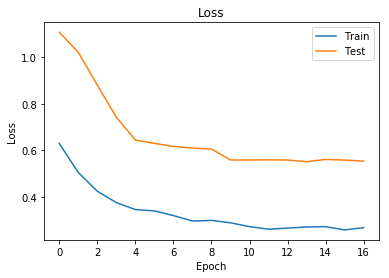

In [26]:
#Let's see if our loss function converges
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [73]:
#Code excerpt from Scikit-Learn
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Test Loss:  0.5536261124488635
Test Accuracy:  0.717948717948718


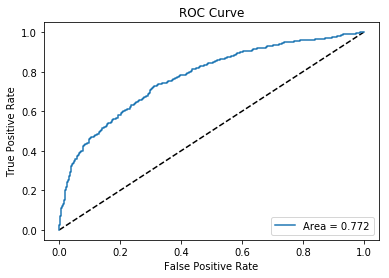

Recall of the model is 0.87
Precision of the model is 0.73
F1 of the model is 0.79


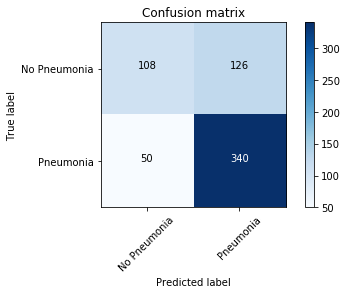

In [81]:
#Helper function that evaluates our model, plots the confusion matrix,
#and calculates precision and recall
def test_model(model, X_test, y_test):
    test_loss, test_score = model.evaluate(X_test, y_test,
                            batch_size = BATCH_SIZE, verbose=0)

    print("Test Loss: ", test_loss)
    print("Test Accuracy: ", test_score)

    # Get predictions
    y_pred = model.predict(X_test, batch_size=BATCH_SIZE)

    #Produce ROC Curve
    fp, tp, _ = roc_curve(y_test.ravel(), y_pred.ravel())
    model_auc = auc(fp, tp)
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fp, tp, label='Area = {:.3f}'.format(model_auc))
    plt.legend(loc='lower right')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

    #Flatten probabilities to calculate confusion matrix
    y_pred = np.argmax(y_pred, axis=-1)
    y_true = np.argmax(y_test, axis=-1)

    # Get the confusion matrix
    cm  = confusion_matrix(y_true, y_pred)

    # Calculate Precision and Recall
    true_neg, false_pos, false_neg, true_pos = cm.ravel()
    precision = true_pos/(true_pos+false_pos)
    recall = true_pos/(true_pos+false_neg)
    F1 = 2 * (precision * recall) / (precision + recall)
    print("Recall of the model is {:.2f}".format(recall))
    print("Precision of the model is {:.2f}".format(precision))
    print("F1 of the model is {:.2f}".format(F1))

    plot_confusion_matrix(cm, ['No Pneumonia', 'Pneumonia'])

In [ ]:
test_model(model, X_test, y_test)